## Dépendance logicielle

Ce notebook dépend des bibliothèques suivantes :
- Python3: pandas, numpy, scipy, matplotlib, time

In [278]:
%matplotlib inline
import numpy as np
import scipy.spatial.distance as dist
import matplotlib.pyplot as plt
import time
import pandas as pd

In [235]:
import IPython
print(IPython.sys_info())
np.__version__

{'commit_hash': 'b467d487e',
 'commit_source': 'installation',
 'default_encoding': 'UTF-8',
 'ipython_path': '/usr/lib/python3/dist-packages/IPython',
 'ipython_version': '5.5.0',
 'os_name': 'posix',
 'platform': 'Linux-4.2.0-1-amd64-x86_64-with-debian-stretch-sid',
 'sys_executable': '/usr/bin/python3',
 'sys_platform': 'linux',
 'sys_version': '3.6.3 (default, Oct  3 2017, 21:16:13) \n[GCC 7.2.0]'}


'1.13.1'

# Partie A: Données synthétiques

## Question 1

In [236]:
N=1000
M=100
exp_end = 10

def ratios(nb_data, nb_requests, dim):
    t0 = time.clock() # process time is different then wall time
    x = np.random.randn(nb_data,dim) # data
    y = np.random.randn(nb_requests,dim) # requests
    z = dist.cdist(y,x,'euclidean') # euclidean distance 
    minimums=z.min(1)
    maximums=z.max(1)
    time_taken = time.clock() - t0
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Elapsed' : time_taken, 
                         'N' : nb_data, 
                         'D' : dim})

In [237]:
def ratios_dataframe(nb_data, nb_requests, exp_end):
    results = []
    frames = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        frames.append(ratios(nb_data, nb_requests, dim))
    return pd.concat(frames)

results = ratios_dataframe(N, M, exp_end)

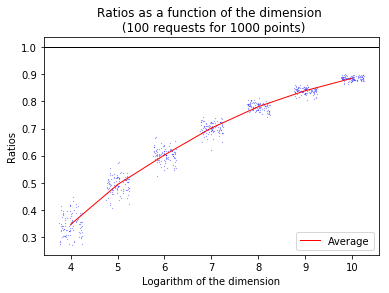

In [238]:
def plot_ratios(res, nb_data, nb_requests, exp_end):
    means = []
    jitter = np.random.rand(nb_requests)
    
    for i in range(4, exp_end+1):
        dim = 2 ** i
        x = (jitter - 0.5) * .5 + i 
        y = (res['Ratios'][(res['D'] == dim)].values)
        plt.plot(x, y, 'b.', markersize = .3)
        means.append(np.mean(y))

    avg, = plt.plot(np.arange(4, exp_end+1), means, linewidth= 1, color = 'red')
    plt.axhline(y=1, color='black', linestyle='-', linewidth = 1)

    plt.title("Ratios as a function of the dimension \n (" +
              str(nb_requests) + " requests for " +
              str(nb_data) + " points)")
    plt.xlabel("Logarithm of the dimension")
    plt.ylabel("Ratios")
    plt.legend([avg], ["Average"])
    plt.show()
    
plot_ratios(results, N, M, exp_end)

Nous conjecturons que le ratio moyen tend vers 1 à N et M fixé quand la dimension augmente. C'est la "malédiction de la dimensionalité".

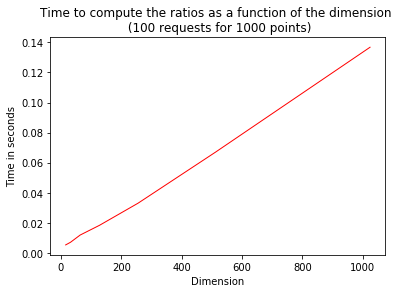

In [239]:
def plot_time(res, nb_data, nb_requests, exp_end):
    times = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        y = (results['Elapsed'][(results['D'] == dim)].values[0])
        times.append(y)

    plt.plot([2**i for i in range(4, exp_end +1)], times, linewidth= 1, color = 'red')
    plt.title("Time to compute the ratios as a function of the dimension \n (" + 
              str(nb_requests) + " requests for " +
              str(nb_data) + " points)")
    plt.xlabel("Dimension")
    plt.ylabel("Time in seconds")
    plt.show()
    
plot_time(results, N, M, exp_end)

La compléxité semble bien linéaire en la dimension.

Même calculs avec N plus grand.

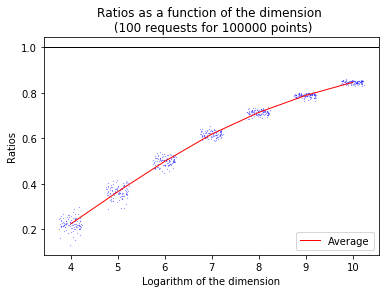

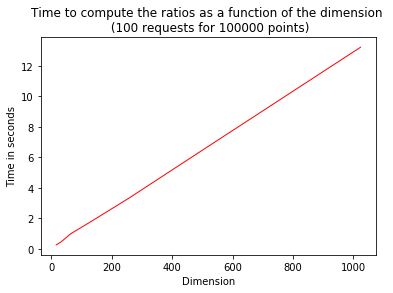

In [240]:
N = 10**5
results = ratios_dataframe(N, M, 10)
plot_ratios(results, N, M, 10)
plot_time(results, N, M, 10)

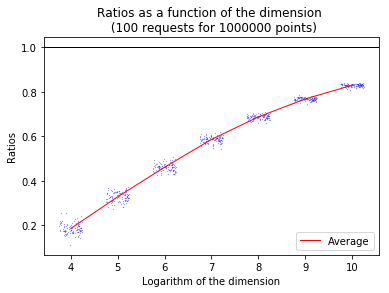

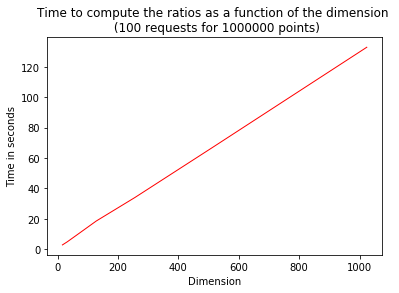

In [241]:
N = 10**6
results = ratios_dataframe(N, M, 10)
plot_ratios(results, N, M, 10)
plot_time(results, N, M, 10)

Nous remarquons plusieurs choses: premieremement, les ratios semblent moins dispersés autour de la valeur moyenne quand N augmente.
De plus, le ratio moyen est plus faible quand le nombdre de donnée augmente.

## Question 2

In [242]:
N = 1000
M = 100
D = 32

In [269]:
def random_norm_pos(n, dim):
    mean = np.zeros(dim)
    cov = np.identity(dim)
    x = np.random.multivariate_normal(mean, cov, n)
    normed_x = x / np.linalg.norm(x, axis=-1)[:, np.newaxis]
    positiv_x = np.asarray(list(map(np.absolute, normed_x)))
    return positiv_x

In [270]:
points = random_norm_pos(N,D)
requests = random_norm_pos(M, D)

## Question 3 

In [271]:
def ratios_hypersphere_pos(nb_data, nb_requests, dim):
    t0 = time.clock() # process time is different then wall time
    x = random_norm_pos(nb_data, dim) # data
    y = random_norm_pos(nb_requests, dim) # requests
    z = dist.cdist(y,x,'euclidean') # euclidean distance 
    minimums=z.min(1)
    maximums=z.max(1)
    time_taken = time.clock() - t0
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Elapsed' : time_taken, 
                         'N' : nb_data, 
                         'D' : dim})

In [275]:
def ratios_hypersphere_dataframe(nb_data, nb_requests, exp_end):
    results = []
    frames = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        frames.append(ratios_hypersphere_pos(nb_data, nb_requests, dim))
    return pd.concat(frames)

results = ratios_hypersphere_dataframe(N, M, exp_end)

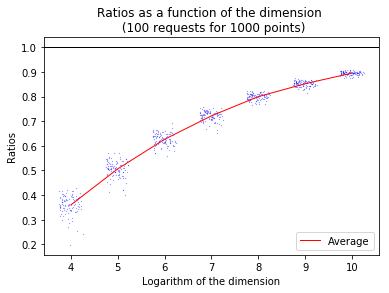

In [277]:
plot_ratios(results, N, M, exp_end)

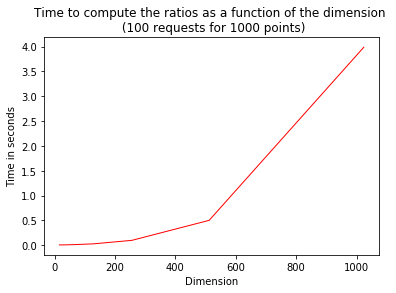

In [276]:
plot_time(results, N, M, exp_end)

La complexité n'est plus linéaire, en effet, lors de la création des vecteurs, nous créons une matrice de covariance, la complexité devient donc quadratique.

## Question 4 

### Hub 

Nous pouvons supposer que le vecteur de dimension D dont toutes les composantes sont égales est un hub. 

Cette hypothèse vient du raisonnement suivant:

notons SHP le cadran positif de l'hypersphère unité de dimension D,

soit v l'unique vecteur de SHP sont toutes les composantes sont égales.

v minimise max{|v-x| | x appartient à SHP}.

### Anti-Hub 

Nous pouvons supposer que les vecteurs de la base canonique sont des anti-hub.

Cette hypothèse vient du fait qu'ils maximise max{|e-x| | x appartient à SHP}.

## Question 5

In [249]:
N = 1000
M = 100
D = 3

In [259]:
def normalize(vect):
    return vect/np.linalg.norm(vect, axis=-1)

In [260]:
def ratios_hypersphere_pos_hub(nb_data, nb_requests, dim):
    t0 = time.clock() # process time is different then wall time
    
    x = random_norm_pos(nb_data-2, dim) # data
    hub = np.ones(dim)
    hub = normalize(hub)
    anti_hub = np.zeros(dim)
    anti_hub[0] = 1
    x = np.insert(x, 0, hub) # it will be in first position in the array
    x = np.insert(x, (nb_data-1)*dim, anti_hub) # it will be in last position in the array
    x.shape= (nb_data,dim)

    y = random_norm_pos(nb_requests, dim) # requests
    z = dist.cdist(y,x,'euclidean') # euclidean distance 
    
    minimums=z.min(1)
    maximums=z.max(1)
    
    ranks = np.asarray(list(map(np.argsort, z))) 
    hub_ranks = np.fromiter(map(np.argmin, ranks), dtype=np.int)
    anti_hub_ranks = np.fromiter(map(np.argmax, ranks), dtype=np.int)

    time_taken = time.clock() - t0
    return pd.DataFrame({'Ratios' : (minimums/maximums).tolist(), 
                         'Hub_ranks' : hub_ranks,
                         'Anti_hub_ranks': anti_hub_ranks, 
                         'Elapsed' : time_taken, 
                         'N' : nb_data, 
                         'D' : dim})

In [253]:
def ratios_hypersphere_hub_dataframe(nb_data, nb_requests, exp_end):
    results = []
    frames = []

    for i in range(4, exp_end+1):
        dim = 2 ** i
        frames.append(ratios_hypersphere_pos_hub(nb_data, nb_requests, dim))
    return pd.concat(frames)

results = ratios_hypersphere_hub_dataframe(N, M, exp_end)

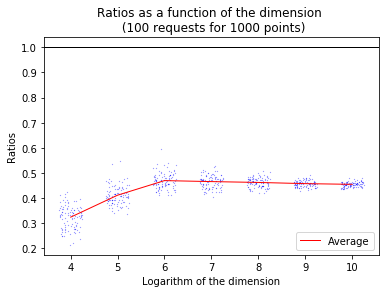

In [254]:
plot_ratios(results, N, M, exp_end)

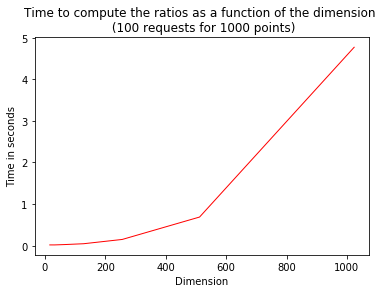

In [255]:
plot_time(results, N, M, exp_end)

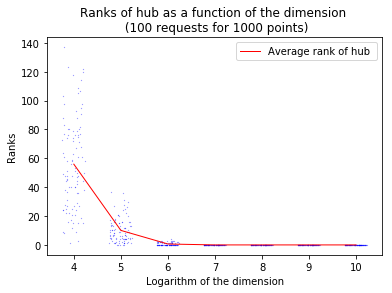

In [256]:
def plot_hub_ranks(res, nb_data, nb_requests, exp_end):
    hub_means = []
    jitter = np.random.rand(nb_requests)
    
    for i in range(4, exp_end+1):
        dim = 2 ** i
        x = (jitter - 0.5) * .5 + i 
        h = (res['Hub_ranks'][(res['D'] == dim)].values)
        plt.plot(x, h, 'b.', markersize = .3)
        hub_means.append(np.mean(h))
        
    hub_avg, = plt.plot(np.arange(4, exp_end+1), hub_means, linewidth= 1, color = 'red')
    
    plt.title("Ranks of hub as a function of the dimension \n (" + 
              str(nb_requests) + " requests for " + 
              str(nb_data) + " points)")
    plt.xlabel("Logarithm of the dimension")
    plt.ylabel("Ranks")
    plt.legend([hub_avg], ["Average rank of hub "])
    plt.show()
    
plot_hub_ranks(results, N, M, exp_end)

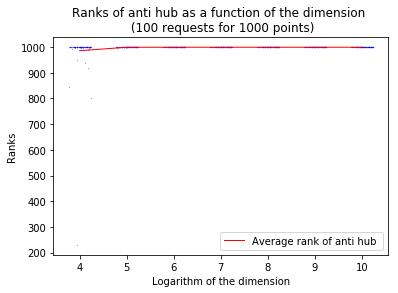

In [258]:
def plot_anti_hub_ranks(res, nb_data, nb_requests, exp_end):
    anti_hub_means = []
    jitter = np.random.rand(nb_requests)
    
    for i in range(4, exp_end+1):
        dim = 2 ** i
        x = (jitter - 0.5) * .5 + i 
        ah = (res['Anti_hub_ranks'][(res['D'] == dim)].values)
        plt.plot(x, ah, 'b.', markersize = .3)
        anti_hub_means.append(np.mean(ah))
        
    anti_hub_avg, = plt.plot(np.arange(4, exp_end+1), anti_hub_means, linewidth= 1, color = 'red')
    
    plt.title("Ranks of anti hub as a function of the dimension \n (" + 
              str(nb_requests) + " requests for " + 
              str(nb_data) + " points)")
    plt.xlabel("Logarithm of the dimension")
    plt.ylabel("Ranks")
    plt.legend([anti_hub_avg], ["Average rank of anti hub "])
    plt.show()
    
plot_anti_hub_ranks(results, N, M, exp_end)

Les deux précédents graphiques corroborent les conjectures de la question précédente.

## Question 6 (bonus)

In [378]:
def ratios_moving_point_dataframe(nb_data, nb_requests, exp_end):
    results = []
    frames = []
    for i in range(4, exp_end+1):
        dim = 2 ** i
        
        hub = np.ones(dim)
        hub = normalize(hub)
        anti_hub = np.zeros(dim)
        anti_hub[0] = 1
    
        x = random_norm_pos(nb_data -1, dim) # data
        y = random_norm_pos(nb_requests, dim) # requests
        z = dist.cdist(y,x,'euclidean') # euclidean distance 
    
        for k in range(10):
            moving_point = (1-k/9)*hub + k/9*anti_hub
            moving_point = normalize(moving_point)
            
            distance = dist.cdist(np.array([moving_point]),y,'euclidean')
            #print(distance.shape)
            #print(distance)
            #print(z.shape)
            #print(z)
            current_ratios = np.concatenate((distance, z.T), axis = 0).T
            #print(current_ratios.shape)
            ranks = np.asarray(list(map(np.argsort, current_ratios))) 
            moving_point_ranks = np.fromiter(map(np.argmin, ranks), dtype=np.int)
            
            frames.append(pd.DataFrame({'K' : k,
                                        'D' : dim,
                                        'Ranks' : moving_point_ranks.tolist()}))                         
    
    return pd.concat(frames)

results = ratios_moving_point_dataframe(N, M, 10)

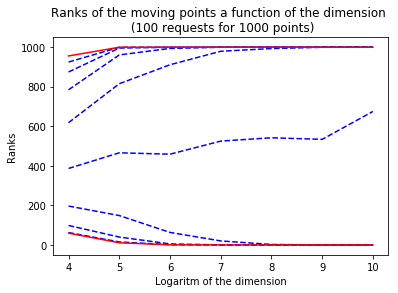

In [388]:
def plot_moving_point_ranks(res, nb_data, nb_requests, exp_end, k_max):
    jitter = np.random.rand(nb_requests)
    means = [[ np.mean(((res[['Ranks']][(res['K'] == k) & (res['D'] == 2**i)]).values), axis = 0)[0]
              for i in range(4, exp_end +1)] 
             for k in range(k_max)]
    
    for k in range(1, k_max -1):
        y = means[k]
        plt.plot(range(4, exp_end+1), y, 'b--', markersize = .3)
    
    y = means[0]
    plt.plot(range(4, exp_end+1), y, 'r-', markersize = .2)
    y = means[-1]
    plt.plot(range(4, exp_end+1), y, 'r-', markersize = .2)
    
    plt.title("Ranks of the moving points a function of the dimension \n (" + 
              str(nb_requests) + " requests for " + 
              str(nb_data) + " points)")
    plt.ylabel("Ranks")
    plt.xlabel("Logaritm of the dimension")
    plt.show()

plot_moving_point_ranks(results, N, M, 10, 10)
